In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
data_dir = '/content/drive/MyDrive/dataset'
batch_size = 34
img_size = (224, 224)
epochs = 30
validation_split = 0.3

In [ ]:
datagen_display = ImageDataGenerator(rescale=1./255)
generator_display = datagen_display.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 14074 images belonging to 10 classes.
Found 9857 images belonging to 10 classes.
Found 4217 images belonging to 10 classes.


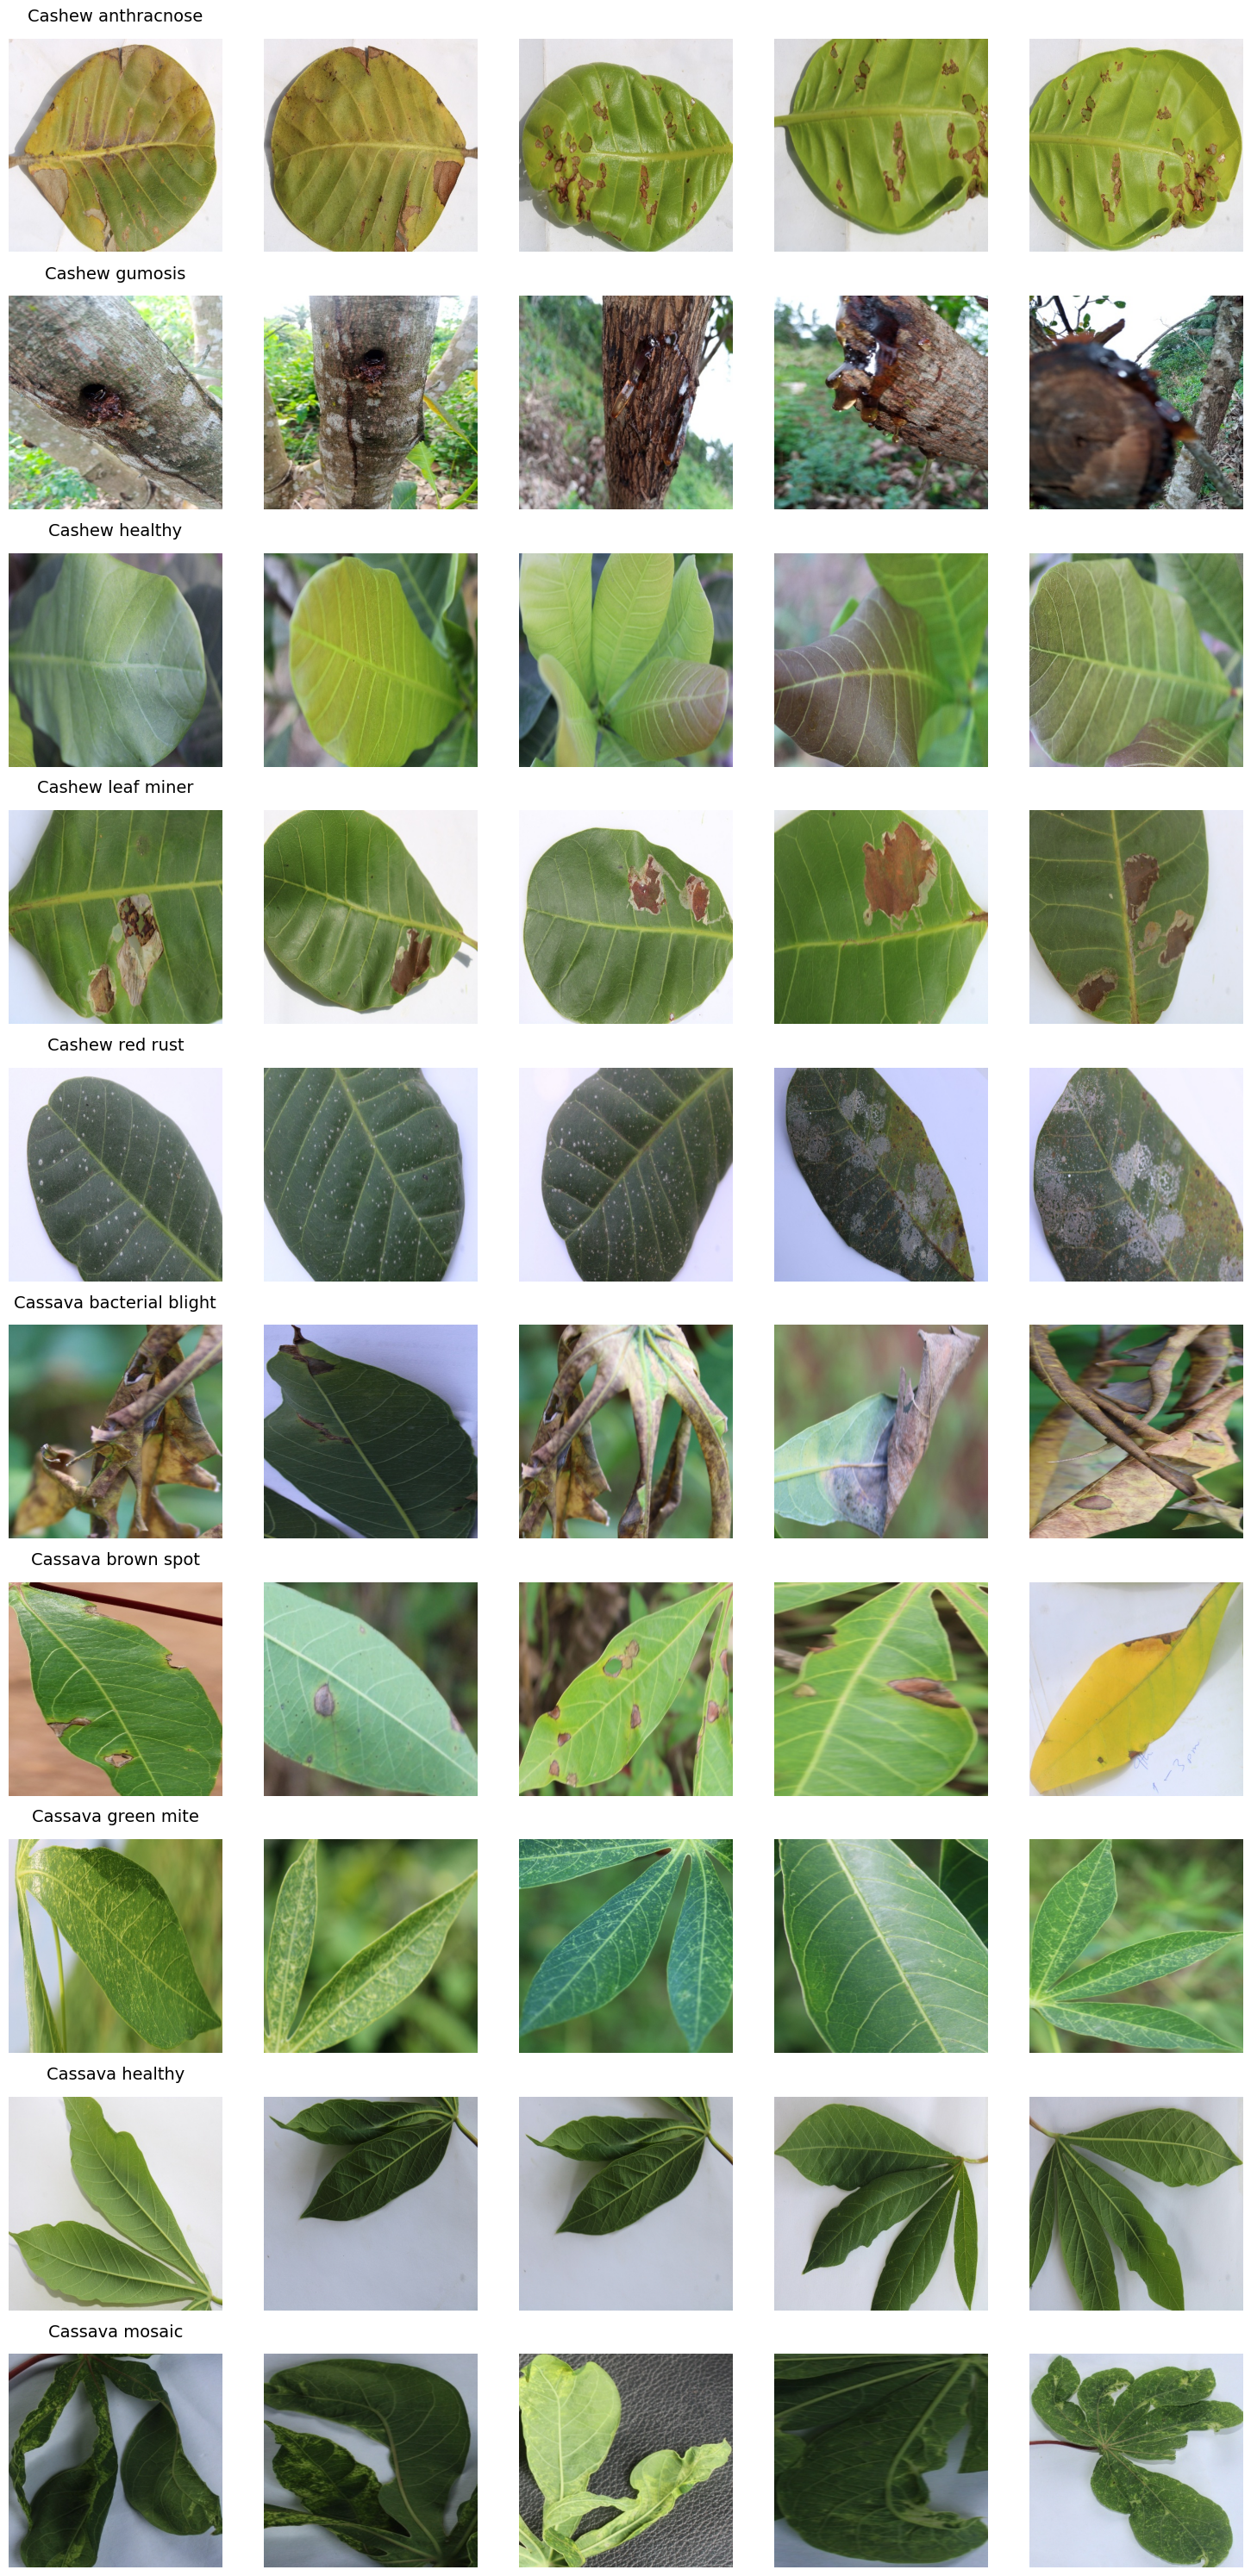

In [ ]:
class_indices = generator_display.class_indices
classes = list(class_indices.keys())

import matplotlib.pyplot as plt

def plot_class_samples(generator, classes, num_samples=5):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    axes = axes.ravel()

    for idx, class_name in enumerate(classes):
        class_images = [image for image, label in zip(generator.filepaths, generator.classes) if label == idx]
        for i in range(num_samples):
            img = plt.imread(class_images[i])
            axes[idx * num_samples + i].imshow(img)
            axes[idx * num_samples + i].axis('off')
            if i == 0:
                axes[idx * num_samples + i].set_title(class_name, fontsize=14, pad=15)

    plt.tight_layout()
    plt.show()

plot_class_samples(generator_display, classes, num_samples=5)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

fine_tune_at = 100

# Unfreeze some of the top layers
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


290/290 ━━━━━━━━━━━━━━━━━━━━ 5135s 17s/step - accuracy: 0.1028 - loss: 4.1565 - val_accuracy: 0.2718 - val_loss: 2.0745
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 245s 629ms/step - accuracy: 0.1589 - loss: 2.5189 - val_accuracy: 0.3633 - val_loss: 1.9335
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 187s 633ms/step - accuracy: 0.2147 - loss: 2.2521 - val_accuracy: 0.4420 - val_loss: 1.7637
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 188s 638ms/step - accuracy: 0.2659 - loss: 2.0723 - val_accuracy: 0.5023 - val_loss: 1.5798
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 208s 704ms/step - accuracy: 0.3223 - loss: 1.9191 - val_accuracy: 0.5627 - val_loss: 1.3885
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 241s 631ms/step - accuracy: 0.3698 - loss: 1.7885 - val_accuracy: 0.6066 - val_loss: 1.2483
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 185s 625ms/step - accuracy: 0.4230 - loss: 1.6515 - val_accuracy: 0.6419 - val_loss: 1.1180
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 222s 697ms/step - accuracy: 0.4592 - loss: 1.539

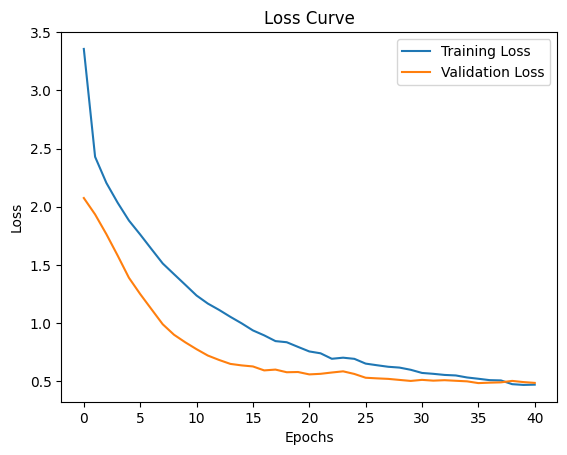

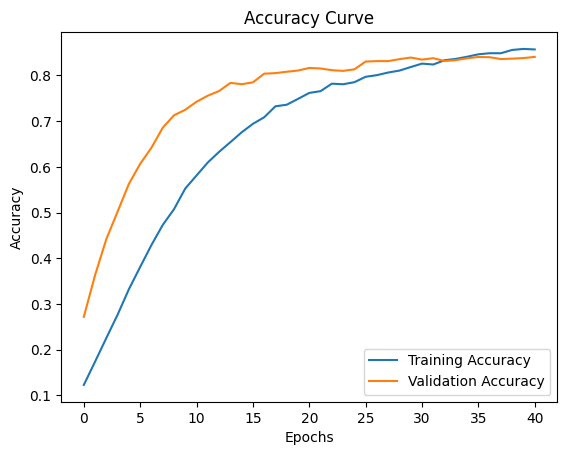

In [ ]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step
Classification Report:
                          precision    recall  f1-score   support

      Cashew anthracnose       0.76      0.70      0.72       518
          Cashew gumosis       0.94      1.00      0.97       117
          Cashew healthy       0.85      0.94      0.89       410
       Cashew leaf miner       0.78      0.62      0.69       413
         Cashew red rust       0.93      0.98      0.96       507
Cassava bacterial blight       0.78      0.84      0.81       784
      Cassava brown spot       0.73      0.82      0.77       446
      Cassava green mite       0.93      0.75      0.83       304
         Cassava healthy       0.96      0.96      0.96       357
          Cassava mosaic       0.94      0.93      0.94       361

                accuracy                           0.84      4217
               macro avg       0.86      0.85      0.85      4217
            weighted avg       0.84      0.84      0.84      4217



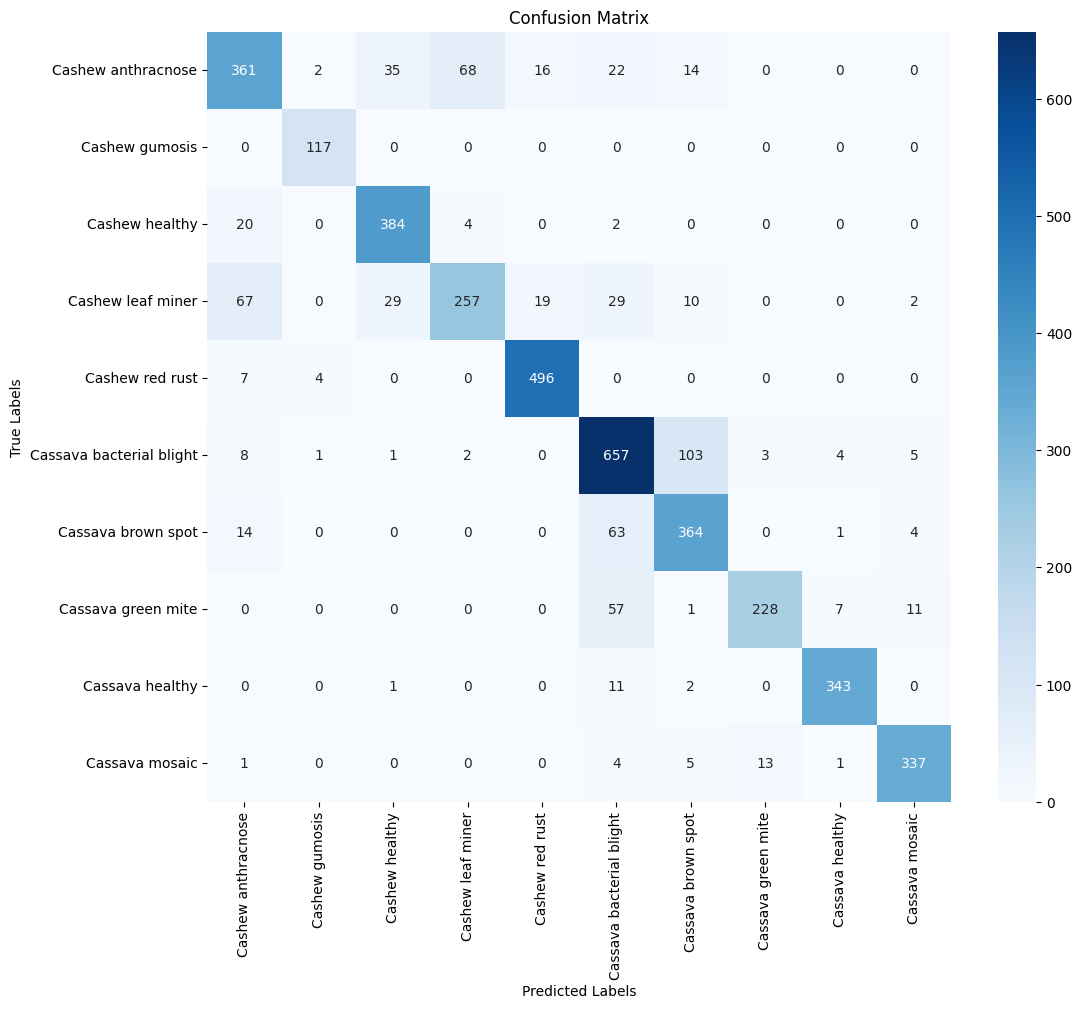

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_generator.reset()
predictions = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes[:len(y_pred)]

class_labels = list(val_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
from tensorflow import keras

# Menyimpan model ke format HDF5
model.save('/content/drive/MyDrive/models/petis2.h5')

In [ ]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model ke format TFLite
with open('/content/drive/MyDrive/models/petis2.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp0eozp7u_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134086433047296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086434438864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086434432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086434437632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086434429184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086434435520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086463319104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086433362464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086433362640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134086433465520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1340864472728